In [530]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import random as rd

df = pd.read_csv("house_data_sampled.csv").sample(100)
df.head()
df.columns

Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [531]:
sqft_linspace = np.linspace(df['sqft_living'].min(),df['sqft_living'].max())

data = {'N': len(sqft_linspace),
        'sqft': sqft_linspace}
one_param_ppc_a = CmdStanModel(stan_file='one_param_ppc_a.stan')
one_param_ppc_a_simulated = one_param_ppc_a.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [532]:
one_param_ppc_a_simulated.summary().head()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
alpha,44000.0,78.0,2500.0,40000.0,44000.0,48000.0,1100.0,28000.0,1.0
beta,280.0,4.9,150.0,36.0,280.0,530.0,930.0,25000.0,1.0
sigma,350.0,13.0,330.0,20.0,250.0,1100.0,710.0,19000.0,1.0
price[1],244077.0,3560.0,108743.0,67492.0,241965.0,425573.0,933.0,24555.0,1.0


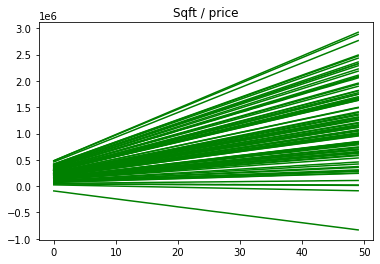

In [533]:
prices_sim=one_param_ppc_a_simulated.stan_variable('price')
for i in range(0,len(df['sqft_living'])):
    plt.plot(range(len(sqft_linspace)), prices_sim[i], color="g")

# plt.scatter(df['sqft_living'], df["price"])

plt.title("Sqft / price")
plt.show()

In [534]:
sqft_linspace = np.linspace(df['sqft_living'].min(),df['sqft_living'].max())


data = {'N': len(sqft_linspace),
        'sqft': sqft_linspace}
one_param_ppc_b = CmdStanModel(stan_file='one_param_ppc_b.stan')
one_param_ppc_b_simulated = one_param_ppc_b.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


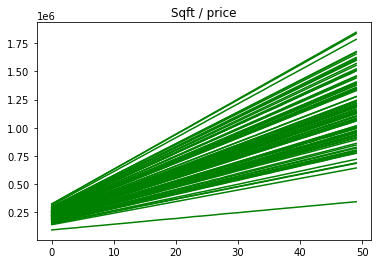

In [535]:
prices_sim=one_param_ppc_b_simulated.stan_variable('price')

for i in range(0,len(df['sqft_living'])):
    plt.plot(range(len(sqft_linspace)), prices_sim[i], color="g")

# plt.scatter(df['sqft_living'], df["price"])

plt.title("Sqft / price")
plt.show()

## Model 2 Posterior

In [536]:
data = {'N': len(df['sqft_living']),
        'sqft': df['sqft_living'],
        'price': df['price']}
one_param = CmdStanModel(stan_file='one_param.stan')
one_param_simulated = one_param.sample(data=data, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


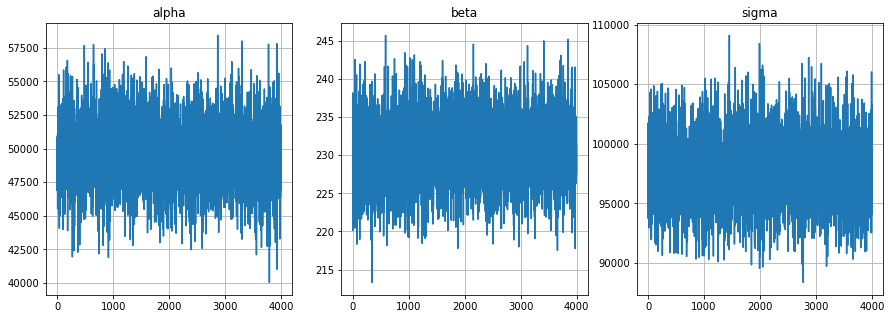

,mean,sd,hdi_3%,hdi_97%
alpha,49679.16,2482.38,45004.70,54189.50
beta,230.78,4.45,221.86,238.56
sigma,97688.25,2896.73,92506.80,103424.00


In [537]:
alpha_sim = one_param_simulated.stan_variable('alpha')
beta_sim = one_param_simulated.stan_variable('beta')
sigma_sim = one_param_simulated.stan_variable('sigma')
price_sim = one_param_simulated.stan_variable('price_sim')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].plot(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].plot(beta_sim)
axs[1].grid()
axs[1].set_title('beta')
axs[2].plot(sigma_sim)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(one_param_simulated,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

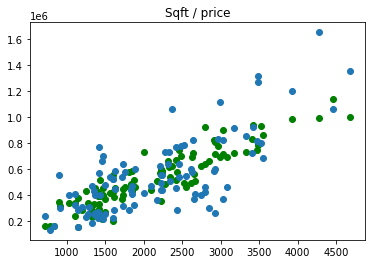

In [538]:
prices_sim=one_param_simulated.stan_variable('price_sim')

# for i in range(0,len(df['sqft_living'])):
plt.scatter(df['sqft_living'], prices_sim[1], color="g")

plt.scatter(df['sqft_living'], df["price"])

plt.title("Sqft / price")
plt.show()

## Adding second predictor to model

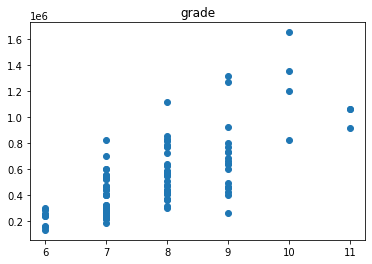

In [539]:
plt.scatter(df['grade'], df["price"])
plt.title("grade")
plt.show()

In [540]:
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm


X = df[['sqft_living', 'grade']] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = df['price']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

print(model.summary())

Intercept: 
 -455991.08748734824
Coefficients: 
 [  164.62748343 82005.56326892]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     70.74
Date:                Mon, 13 Jun 2022   Prob (F-statistic):           1.13e-19
Time:                        19:18:22   Log-Likelihood:                -1353.2
No. Observations:                 100   AIC:                             2712.
Df Residuals:                      97   BIC:                             2720.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

### Prior predictive check

In [541]:
sqft_linspace = np.linspace(df['sqft_living'].min(),df['sqft_living'].max())
grade_linspace = np.linspace(df['grade'].min(),df['grade'].max())

data = {'N': len(sqft_linspace),
        'sqft': sqft_linspace,
        'grade': grade_linspace}
two_params_ppc = CmdStanModel(stan_file='two_params_ppc.stan')
two_params_ppc_simulated = two_params_ppc.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:compiling stan file /home/nicolas/Projects/DA_project/two_params_ppc.stan to exe file /home/nicolas/Projects/DA_project/two_params_ppc
INFO:cmdstanpy:compiled model executable: /home/nicolas/Projects/DA_project/two_params_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


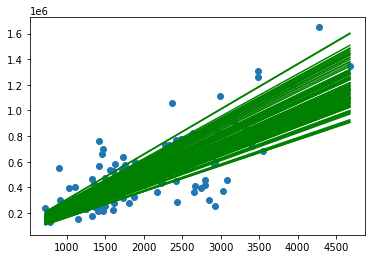

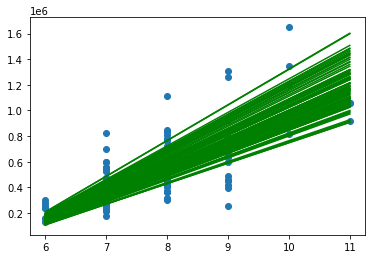

In [542]:
prices_sim=two_params_ppc_simulated.stan_variable('price')

plt.scatter(df['sqft_living'],df['price'])
for i in range(0,len(df['sqft_living'])):
    plt.plot(sqft_linspace, prices_sim[i], color="g")
plt.show()


for i in range(0,len(df['sqft_living'])):
    plt.plot(grade_linspace, prices_sim[i], color="g")

plt.scatter(df['grade'],df['price'])



In [543]:
data = {'N': len(df['sqft_living']),
        'sqft_living': df['sqft_living'],
        'grade': df['grade'],
        'price': df['price']}
two_params = CmdStanModel(stan_file='two_params.stan')
two_params_simulated = two_params.sample(data=data, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |█████████ | 00:01 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


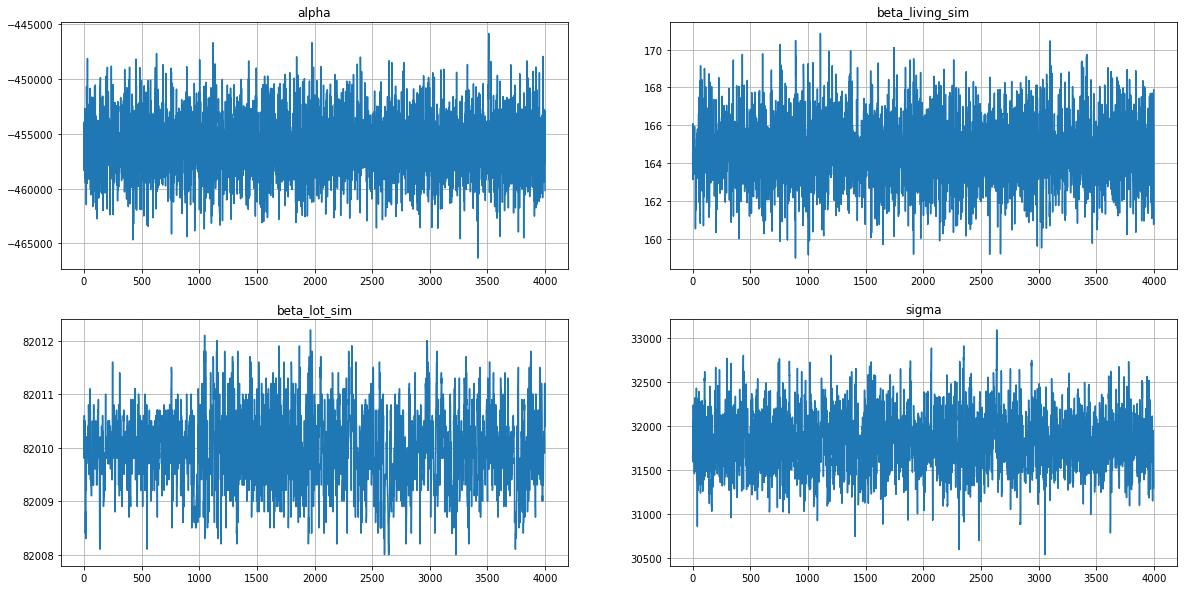

In [544]:
alpha_sim = two_params_simulated.stan_variable('alpha')
beta_living_sim = two_params_simulated.stan_variable('beta_sqft_living')
beta_lot_sim = two_params_simulated.stan_variable('beta_grade')
sigma_sim = two_params_simulated.stan_variable('sigma')
price_sim = two_params_simulated.stan_variable('prices')

fig, axs = plt.subplots(2,2)
fig.set_size_inches(20, 10)
axs[0][0].plot(alpha_sim)
axs[0][0].grid()
axs[0][0].set_title('alpha')
axs[0][1].plot(beta_living_sim)
axs[0][1].grid()
axs[0][1].set_title('beta_living_sim')
axs[1][0].plot(beta_lot_sim)
axs[1][0].grid()
axs[1][0].set_title('beta_lot_sim')
axs[1][1].plot(sigma_sim)
axs[1][1].grid()
axs[1][1].set_title('sigma')
plt.show()


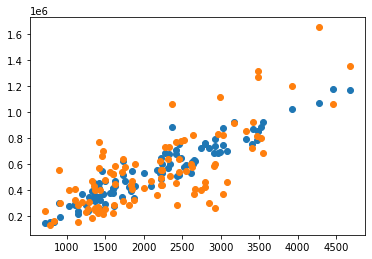

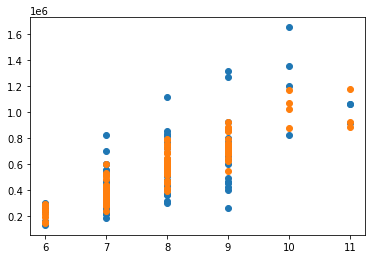

In [545]:
price_sim = two_params_simulated.stan_variable('prices')


plt.scatter(df['sqft_living'],price_sim[0])
plt.scatter(df['sqft_living'],df['price'])
plt.show()

plt.scatter(df['grade'],df['price'])
plt.scatter(df['grade'],price_sim[0])


In [546]:
# Comparing 2 models: model_1 - with AGE only, model_2 - with AGE and BMI
idata1 = az.from_cmdstanpy(posterior = one_param_simulated, log_likelihood = "log_lik")
idata2 = az.from_cmdstanpy(posterior = two_params_simulated, log_likelihood = "log_lik") 
compare_dict = {"one_param_model": idata1, "two_param_model": idata2}

out_loo = az.compare(compare_dict, ic = "loo")
out_waic = az.compare(compare_dict, ic = "waic") # loo stands for leave one out cross validation

/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
one_param_model,0,-1442.354765,10.160059,0.000000,1.000000e+00,32.633926,0.000000,False,log
two_param_model,1,-2817.059361,93.031991,1374.704596,4.722267e-11,289.654791,259.825601,True,log


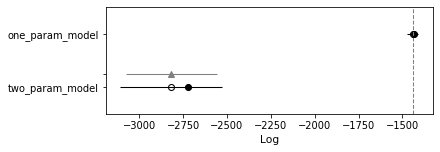

In [547]:
az.plot_compare(out_loo)
out_loo


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
one_param_model,0,-1442.474456,10.279750,0.000000,1.0,32.700735,0.000000,True,log
two_param_model,1,-2824.345878,100.318508,1381.871422,0.0,293.383341,263.439332,True,log


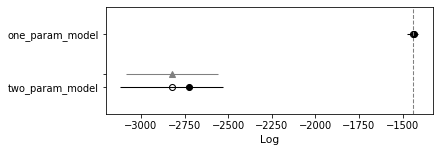

In [549]:
az.plot_compare(out_waic)
out_waic


1. The warnings are most likey caused by the outliers in the data: https://discourse.mc-stan.org/t/number-of-points-with-pareto-k-0-7-increases-when-a-subset-of-the-data-set-is-used/91081.